In [2]:
!pip install  "gymnasium[classic-control]"

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.25a0+6627725-py3.12-linux-x86_64.eg

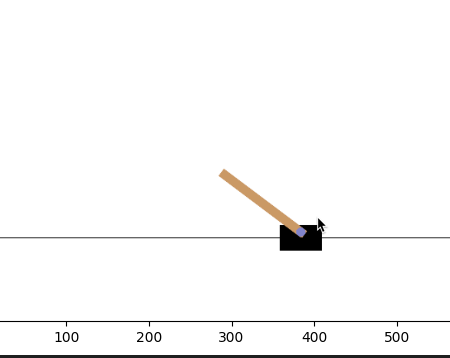

# CartPole State Description

In CartPole, the `state` is a NumPy array of 4 floats representing the following:

| **Component**         | **Description**                                      | **Range**                  |
|-----------------------|-----------------------------------------------------|----------------------------|
| Cart Position         | The x-coordinate of the cart                       | [-4.8, 4.8]                |
| Cart Velocity         | The speed of the cart (positive or negative)       | Unbounded                  |
| Pole Angle            | The angle of the pole from vertical, in radians    | [-0.418, 0.418] (~±24°)    |
| Pole Angular Velocity | The rate at which the pole is tipping              | Unbounded                  |

In [3]:
# Cell 1
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import time
%matplotlib inline

# Cell 2
env = gym.make('CartPole-v1', render_mode='rgb_array')
observation = env.reset()
print("Initial observation:", observation)

Initial observation: (array([-0.01557011,  0.0045109 , -0.01356384,  0.00638323], dtype=float32), {})


In [4]:
# Print the action space object
print("Action space:", env.action_space)

# Get the number of actions (for Discrete spaces)
print("Number of possible actions:", env.action_space.n)

# List all possible actions manually
actions = list(range(env.action_space.n))
print("All possible actions:", actions)

Action space: Discrete(2)
Number of possible actions: 2
All possible actions: [0, 1]


In [5]:

# Cell 3
action = env.action_space.sample()
print("Random action:", action)
observation, reward, terminated, truncated, info = env.step(action)
print("New observation:", observation)
print("Reward:", reward)
print("Terminated:", terminated)
print("Truncated:", truncated)
print("Info:", info)


Random action: 1
New observation: [-0.01547989  0.19982472 -0.01343617 -0.2905482 ]
Reward: 1.0
Terminated: False
Truncated: False
Info: {}


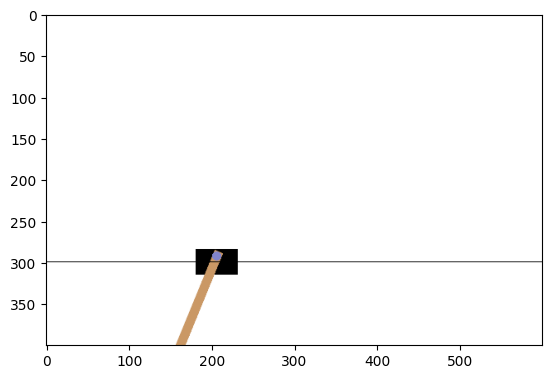

In [6]:

# Cell 4
env.reset()
plt.figure()
for _ in range(50):
    img = env.render()
    plt.imshow(img)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    action = env.action_space.sample()

    observation, reward, terminated, truncated, info = env.step(action)
    # if terminated or truncated:
    #     print("Episode ended!")
    #     break
    time.sleep(0.05)
env.close()

# Train and Simulate

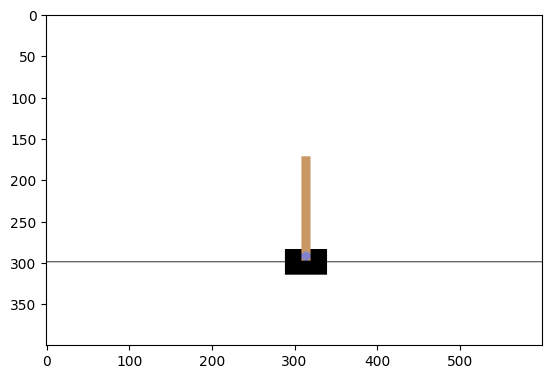

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython import display

# Hyperparameters
learning_rate = 0.01
gamma = 0.99
num_episodes = 1000
max_steps = 500

# Neural Network Policy
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

# Main training function
def train():
    # Initialize environment and network
    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    policy = PolicyNetwork(state_dim, 128, action_dim)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    
    # Store episode statistics
    episode_rewards = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        
        # Generate an episode
        for t in range(max_steps):
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            
            # Get action probabilities
            probs = policy(state_tensor)
            m = Categorical(probs)
            action = m.sample()
            
            # Store log probability
            log_probs.append(m.log_prob(action))
            
            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            
            rewards.append(reward)
            
            state = next_state
            
            if done:
                break
        
        # Calculate returns
        R = 0
        returns = []
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0, R)
        
        # Normalize returns
        returns = torch.FloatTensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        
        # Calculate policy loss
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        # Update policy
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        # Track progress
        total_reward = sum(rewards)
        episode_rewards.append(total_reward)
        
        if episode % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {episode}, Average Reward (last 50): {avg_reward:.2f}")
    
    env.close()
    return policy

# Function to test the trained policy with Jupyter notebook rendering
def test(policy, episodes=5):
    env = gym.make('CartPole-v1', render_mode='rgb_array')  # Changed to rgb_array mode
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        
        for t in range(max_steps):
            # Render and display in notebook
            img = env.render()
            plt.imshow(img)
            display.display(plt.gcf())
            display.clear_output(wait=True)
            
            # Get and take action
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = policy(state_tensor)
            action = torch.argmax(probs).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = next_state
            
            if done:
                break
                
        print(f"Test Episode {episode + 1}, Total Reward: {total_reward}")
    
    plt.close()  # Close the plot when done
    env.close()

if __name__ == "__main__":
    # Train the policy
    trained_policy = train()
    
    # Test the trained policy
    print("\nTesting the trained policy:")
    test(trained_policy)

# Train and Plot reward

Training the policy:
Episode 0, Average Reward (last 50): 18.00
Episode 50, Average Reward (last 50): 116.50
Episode 100, Average Reward (last 50): 163.60
Episode 150, Average Reward (last 50): 156.94
Episode 200, Average Reward (last 50): 231.96
Episode 250, Average Reward (last 50): 138.94
Episode 300, Average Reward (last 50): 266.26
Episode 350, Average Reward (last 50): 500.00
Episode 400, Average Reward (last 50): 205.58
Episode 450, Average Reward (last 50): 37.24
Episode 500, Average Reward (last 50): 79.50
Episode 550, Average Reward (last 50): 44.14
Episode 600, Average Reward (last 50): 55.12
Episode 650, Average Reward (last 50): 367.58
Episode 700, Average Reward (last 50): 424.80
Episode 750, Average Reward (last 50): 47.32
Episode 800, Average Reward (last 50): 108.36
Episode 850, Average Reward (last 50): 207.14
Episode 900, Average Reward (last 50): 500.00
Episode 950, Average Reward (last 50): 500.00

Testing the trained policy:


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


Test Episode 1, Total Reward: 500.0
Test Episode 2, Total Reward: 500.0
Test Episode 3, Total Reward: 500.0
Test Episode 4, Total Reward: 500.0
Test Episode 5, Total Reward: 500.0

Plotting results:


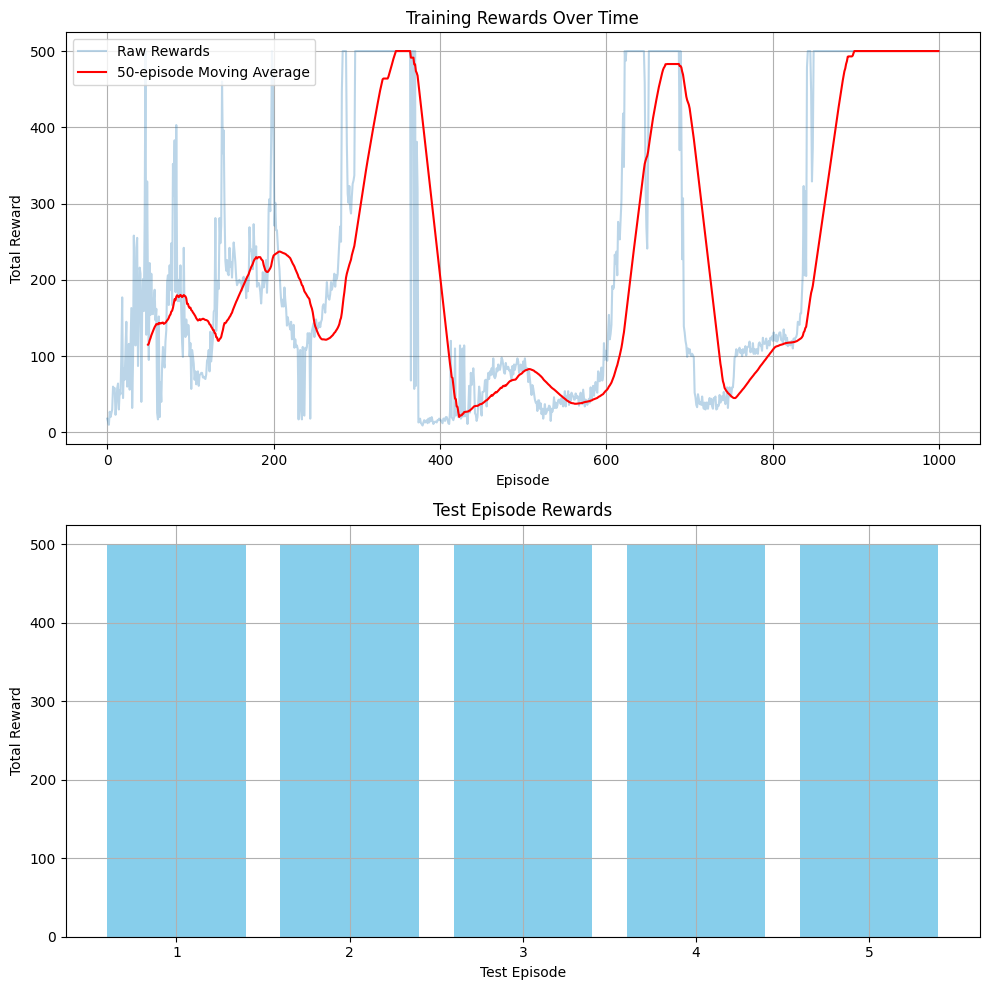

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.01
gamma = 0.99
num_episodes = 1000
max_steps = 500
render_training = False  # Set to True to render during training

# Neural Network Policy
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

# Main training function
def train(render=render_training):
    env = gym.make('CartPole-v1', render_mode='human' if render else None)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    policy = PolicyNetwork(state_dim, 128, action_dim)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    
    episode_rewards = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        
        for t in range(max_steps):
            if render:
                env.render()
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = policy(state_tensor)
            m = Categorical(probs)
            action = m.sample()
            log_probs.append(m.log_prob(action))
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            rewards.append(reward)
            state = next_state
            if done:
                break
        
        R = 0
        returns = []
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0, R)
        
        returns = torch.FloatTensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        total_reward = sum(rewards)
        episode_rewards.append(total_reward)
        
        if episode % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {episode}, Average Reward (last 50): {avg_reward:.2f}")
    
    env.close()
    return policy, episode_rewards

# Function to test the trained policy
def test(policy, episodes=5, render=True):
    env = gym.make('CartPole-v1', render_mode='human' if render else None)
    test_rewards = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        
        for t in range(max_steps):
            if render:
                env.render()
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = policy(state_tensor)
            action = torch.argmax(probs).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = next_state
            if done:
                break
                
        test_rewards.append(total_reward)
        print(f"Test Episode {episode + 1}, Total Reward: {total_reward}")
    
    env.close()
    return test_rewards

# Function to plot results
def plot_results(train_rewards, test_rewards):
    # Calculate moving average for training rewards
    window_size = 50
    moving_avg = np.convolve(train_rewards, np.ones(window_size)/window_size, mode='valid')
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plot 1: Training Rewards
    ax1.plot(train_rewards, label='Raw Rewards', alpha=0.3)
    ax1.plot(range(window_size-1, len(train_rewards)), moving_avg, 
            label=f'{window_size}-episode Moving Average', color='red')
    ax1.set_title('Training Rewards Over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Test Rewards
    episodes = range(1, len(test_rewards) + 1)
    ax2.bar(episodes, test_rewards, color='skyblue')
    ax2.set_title('Test Episode Rewards')
    ax2.set_xlabel('Test Episode')
    ax2.set_ylabel('Total Reward')
    ax2.grid(True)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train the policy and get training rewards
    print("Training the policy:")
    trained_policy, train_rewards = train(render=render_training)  # Set render_training=True to see training
    
    # Test the trained policy and get test rewards
    print("\nTesting the trained policy:")
    test_rewards = test(trained_policy, render=True)  # Render is True by default for testing
    
    # Plot the results
    print("\nPlotting results:")
    plot_results(train_rewards, test_rewards)